# Libraries

In [13]:
import os
import glob
import math
from typing import Any, Dict, List
from dataclasses import dataclass

from collections import defaultdict

from src.pipeline.dataloader import DataLoader, FrameFilters, FrameTransformers, DataLoaderConfig
from src.pipeline.taskloader import TaskLoader, TaskFrame

from src.settings.strategy import Strategy
from src.settings.tier import Tier

from src.models.linear import GLM

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from scipy.stats import pearsonr

In [2]:
DataLoader.DATA_FOLDER = './data/training/'
dl = DataLoader()
tl = TaskLoader()

# Model building

In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, GammaRegressor

from sklearn.metrics import mean_absolute_error

In [4]:


def to_cv_params(params: Dict[str, Dict[str, Any]]):
    return [{
        **model_param,
        'regressor__regressor': [model_param['regressor__regressor']]
    } for model_param in params.values()]

In [5]:
to_cv_params(params)

[{'regressor__regressor': [SVR()],
  'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
  'regressor__pca__n_components': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
  'regressor__preprocessor__num__scaler': [MinMaxScaler(),
   StandardScaler(),
   RobustScaler()]},
 {'regressor__regressor': [DecisionTreeRegressor()],
  'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
  'regressor__regressor__max_depth': [5, 10, 20, 15],
  'regressor__pca__n_components': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
  'regressor__preprocessor__num__scaler': [MinMaxScaler(),
   StandardScaler(),
   RobustScaler()]},
 {'regressor__regressor': [ElasticNet()],
  'regressor__regressor__l1_ratio': [0.01, 0.25, 0.5, 0.75, 1],
  'regressor__regressor__tol': [0.01],
  'regressor__pca__n_components': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
  'regressor__preprocessor__num__scaler': [MinMaxScaler(),
   StandardScaler(),
   RobustScaler()]}]

In [6]:
def get_generator(
    strategy:Strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER1,
    config: DataLoaderConfig = DataLoaderConfig()
):
    df = dl.get_dataframe(config)
    gen = tl.prepare_task(df, tier).build(strategy)
    return gen

def build_model_pipeline(
    strategy:Strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER1
):
    tf = next(get_generator(
        strategy, tier
    ))
    
    numeric_features = ['enzyme_concentration'] + tf.x.columns.to_list()
    numeric_features = list(filter(lambda x: x in tf.x.columns.to_list(), numeric_features))
    numeric_transformer = Pipeline(
        steps=[
            ('scaler', StandardScaler())
        ]
    )

    cat_features = ['KO_ORF', 'ORF']
    cat_features = list(filter(lambda x: x in tf.x.index.names, cat_features))

    categorical_transformer = OneHotEncoder(
        categories=[
            y[cat].unique() for cat in cat_features if (y := tf.x.reset_index()) is not None
            # tf.x.reset_index()['KO_ORF'].unique(),
            # tf.x.reset_index()['ORF'].unique()
        ]
    )

    prepocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            # ('cat', categorical_transformer, cat_features),
        ],
        remainder='drop'
    )

    estimator = DecisionTreeRegressor()

    clf = Pipeline(
        steps=[
            ('preprocessor', prepocessor),
            ('pca', PCA()),
            ('regressor', estimator),
        ]
    )

    model = TransformedTargetRegressor(
        regressor=clf,
        transformer=None,
    )
    return model

def cv_result_to_preprocessor(model: TransformedTargetRegressor, c_best_model: pd.DataFrame):
    prefix = 'param_regressor__preprocessor__'

    names = ['MinMaxScaler', 'RobustScaler', 'StandardScaler']
    scalers = [MinMaxScaler(), RobustScaler(), StandardScaler()]

    for name, scaler in zip(names, scalers):
        if all(c_best_model[f'{prefix}num__scaler'].str.contains(name)):
            model.regressor.set_params(
                preprocessor__num__scaler=scaler
            )
    
    return model

def cv_result_to_pca(model: TransformedTargetRegressor, c_best_model: pd.DataFrame):
    prefix = 'param_regressor__pca__'
    model.regressor.set_params(
        pca__n_components=c_best_model[f'{prefix}n_components'].values[0]
    )

    return model
    

def cv_result_to_model(model: TransformedTargetRegressor, c_best_model: pd.DataFrame):
    prefix = 'param_regressor__'
    if all(c_best_model[f'{prefix}regressor'].str.contains('DecisionTreeRegressor')):
        print('DecisionRegressor model')
        # set parameters for decision tree
        model.regressor.set_params(
            regressor=DecisionTreeRegressor(),
            regressor__criterion=c_best_model[f'{prefix}regressor__criterion'].values[0],
            regressor__max_depth=None if math.isnan(r := c_best_model[f'{prefix}regressor__max_depth'].values[0]) else int(r)
        )
    elif all(c_best_model[f'{prefix}regressor'].str.contains('SVR')):
        print('SVR model')
        model.regressor.set_params(
            regressor=SVR(),
            regressor__kernel=c_best_model[f'{prefix}regressor__kernel'].values[0],
        )
    elif all(c_best_model[f'{prefix}regressor'].str.contains('ElasticNet')):
        print('ElasticNet model')
        model.regressor.set_params(
            regressor=ElasticNet(),
            regressor__l1_ratio=c_best_model[f'{prefix}regressor__l1_ratio'].values[0],
        )
    else:
        raise NotImplementedError()

    return model

def parse_cv_result(model: TransformedTargetRegressor, c_best_model: pd.DataFrame):
    model = cv_result_to_preprocessor(model, c_best_model)
    model = cv_result_to_pca(model, c_best_model)
    model = cv_result_to_model(model, c_best_model)
    return model

## Base data model (Tier 0)

In [7]:
EXPERIMENT_ID = 'experiment_0'
PATH_PREFIX = './data/results'
EXPERIMENT_PATH = f'{PATH_PREFIX}/{EXPERIMENT_ID}'
TIER = Tier.TIER0

if not os.path.exists(f'{EXPERIMENT_PATH}'):
    os.makedirs(f'{EXPERIMENT_PATH}')

config = DataLoaderConfig(
    additional_filters=[dl.data_factory.filters.is_precursor],
    additional_transforms=[dl.data_factory.transformer.log_fold_change_protein]
)

cv = RepeatedKFold(n_repeats=1, n_splits=10, random_state=0)

### Strategy All

In [20]:
STRATEGY = Strategy.ALL
params = {
    'SVR': {
        'regressor__regressor': SVR(),
        'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'regressor__pca__n_components': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    },
    'DecisionTreeRegressor': {
        'regressor__regressor': DecisionTreeRegressor(),
        'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
        'regressor__regressor__max_depth': [5, 10, 20, 15],
        'regressor__pca__n_components': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    },
    # 'GammaRegressor': {
    #     'regressor__regressor': GammaRegressor(),
    #     'regressor__regressor__alpha': [0, 1, 10],
    #     'transformer': [MinMaxScaler()]
    # },
    'ElasticNet': {
        'regressor__regressor': ElasticNet(),
        'regressor__regressor__l1_ratio': [0.01, 0.25, 0.5, 0.75, 1],
        'regressor__regressor__tol': [0.01],
        'regressor__pca__n_components': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    }
}

In [9]:
model = build_model_pipeline(tier=TIER)
gen = get_generator(
    strategy=STRATEGY,
    tier=TIER,
    config=config
)
tf = next(gen)


# if not(os.path.exists(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')):
print(f'Training: {tf.title}_{tf.frame_name}.csv')
print(f"{tf.x.shape=} {tf.y.shape}")

df = tf.x.reset_index()
X_train, X_test, y_train, y_test = train_test_split(
    df,
    tf.y,
    test_size=0.3,
    random_state=0,
    stratify=tf.x.reset_index()['metabolite_id']
)

search = GridSearchCV(
    model,
    to_cv_params(params),
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    refit=True,
    cv=cv,
    verbose=1,
    error_score='raise',
)
search.fit(X_train, y_train)

df = pd.DataFrame(search.cv_results_)
df.to_csv(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')

print("model score: %.3f" % search.score(X_test, y_test))

DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])


/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:161: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(
/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:161: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(


DataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.dataloader.FrameTransformers object at 0x7ff32e576ca0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.dataloader.FrameFilters object at 0x7ff32e576dc0>>])
Training: Strategy.ALL_all.csv
tf.x.shape=(737, 726) (737,)
Fitting 10 folds for each of 510 candidates, totalling 5100 fits
model score: -0.376


In [18]:
results_df = pd.read_csv(f'{EXPERIMENT_PATH}/Strategy.ALL_all.csv')
results = defaultdict(lambda: list())
pred_results = defaultdict(lambda: dict())
model = build_model_pipeline(tier=Tier.TIER0)
gen = get_generator(
    strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER0,
    config=config
)

model = parse_cv_result(model, results_df[results_df['rank_test_score'] == 1])
model.get_params()

df = tf.x.reset_index()
X_train, X_test, y_train, y_test = train_test_split(
    df,
    tf.y,
    test_size=0.3,
    random_state=0,
    stratify=tf.x.reset_index()['metabolite_id']
)

model.fit(X_train, y_train)
prediction = model.predict(X_test)

print(f'total sum of squared = {((y_test - y_test.mean()) ** 2).sum()}')
print(f'residual sum of squared = {((y_test - prediction) ** 2).sum()}')
print(f'{y_train.shape=} {y_test.shape=}')
print(f'{model.score(X_test, y_test)}')
print(f'{pearsonr(y_test, prediction)[0]}')

results['all'].append(pearsonr(y_test, prediction)[0])
pred_results['all'].update({
    'y_true': y_test.values,
    'y_pred': model.predict(X_test)
})

for metabolite_id in X_test['metabolite_id'].unique():
    _X_test = X_test[X_test['metabolite_id'] == metabolite_id]
    _y_test = y_test.xs(metabolite_id, level='metabolite_id')
    results[metabolite_id].append(pearsonr(_y_test, model.predict(_X_test))[0])
    pred_results[metabolite_id].update({
        'y_true': _y_test.values,
        'y_pred': model.predict(_X_test)
    })

pd.DataFrame.from_dict(results).to_csv(f'{EXPERIMENT_PATH}/best_model_performance_{STRATEGY}.csv')
pd.DataFrame.from_dict(pred_results).to_json(f'{EXPERIMENT_PATH}/best_model_prediction_performance_{STRATEGY}.json')

DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
DataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.dataloader.FrameTransformers object at 0x7ff32e576ca0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.dataloader.FrameFilters object at 0x7ff32e576dc0>>])


/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:161: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(
/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:161: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(


DecisionRegressor model
total sum of squared = 98.02849433608526
residual sum of squared = 53.23976746712911
y_train.shape=(515,) y_test.shape=(222,)
0.4568949790802711
0.6772126582245629


### Strategy metabolic centric

In [28]:
STRATEGY = Strategy.METABOLITE_CENTRIC
params = {
    'SVR': {
        'regressor__regressor': SVR(),
        'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    },
    'DecisionTreeRegressor': {
        'regressor__regressor': DecisionTreeRegressor(),
        'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
        'regressor__regressor__max_depth': [5, 10, 20, 15],
        'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    },
    # 'GammaRegressor': {
    #     'regressor__regressor': GammaRegressor(),
    #     'regressor__regressor__alpha': [0, 1, 10],
    #     'transformer': [MinMaxScaler()]
    # },
    'ElasticNet': {
        'regressor__regressor': ElasticNet(),
        'regressor__regressor__l1_ratio': [0.01, 0.25, 0.5, 0.75, 1],
        'regressor__regressor__tol': [0.01],
        'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    }
}

In [29]:
model = build_model_pipeline(tier=TIER)
gen = get_generator(
    strategy=STRATEGY,
    tier=TIER,
    config=config
)

for tf in gen:
    # if not(os.path.exists(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')):
    print(f'Training: {tf.title}_{tf.frame_name}.csv')
    print(f"{tf.x.shape=} {tf.y.shape}")

    df = tf.x.reset_index()
    X_train, X_test, y_train, y_test = train_test_split(
        df,
        tf.y,
        test_size=0.2,
        random_state=0,
        shuffle=False
    )

    search = GridSearchCV(
        model,
        to_cv_params(params),
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        refit=True,
        cv=cv,
        verbose=1,
        error_score='raise',
    )
    search.fit(X_train, y_train)

    df = pd.DataFrame(search.cv_results_)
    df.to_csv(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')

    print("model score: %.3f" % search.score(X_test, y_test))
    print(search.best_params_)

DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
DataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.dataloader.FrameTransformers object at 0x7ff32e576ca0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.dataloader.FrameFilters object at 0x7ff32e576dc0>>])
Training: Strategy.METABOLITE_CENTRIC_g6p;g6p-B.csv
tf.x.shape=(18, 726) (18,)
Fitting 10 folds for each of 255 candidates, totalling 2550 fits


/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:161: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(
/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:161: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(


model score: -0.175
{'regressor__pca__n_components': 0.99, 'regressor__preprocessor__num__scaler': RobustScaler(), 'regressor__regressor': DecisionTreeRegressor(criterion='friedman_mse', max_depth=10), 'regressor__regressor__criterion': 'friedman_mse', 'regressor__regressor__max_depth': 10}
Training: Strategy.METABOLITE_CENTRIC_g6p;f6p;g6p-B.csv
tf.x.shape=(95, 726) (95,)
Fitting 10 folds for each of 255 candidates, totalling 2550 fits
model score: -0.164
{'regressor__pca__n_components': 0.1, 'regressor__preprocessor__num__scaler': RobustScaler(), 'regressor__regressor': SVR(kernel='poly'), 'regressor__regressor__kernel': 'poly'}
Training: Strategy.METABOLITE_CENTRIC_f6p.csv
tf.x.shape=(95, 726) (95,)
Fitting 10 folds for each of 255 candidates, totalling 2550 fits
model score: -0.419
{'regressor__pca__n_components': 0.75, 'regressor__preprocessor__num__scaler': MinMaxScaler(), 'regressor__regressor': SVR(kernel='linear'), 'regressor__regressor__kernel': 'linear'}
Training: Strategy.ME

In [30]:
paths = glob.glob(EXPERIMENT_PATH + "/*.csv")

metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
results_df = pd.concat([
    pd.read_csv(path).assign(metabolite_id=metabolite_name) 
    for path, metabolite_name in zip(paths, metabolites_names)
])
results_df = results_df[(
    (results_df['param_regressor__regressor'].str.contains('DecisionTreeRegressor', na=False)) & \
    (results_df['param_regressor__regressor__max_depth'] > 0)
) | \
    (~results_df['param_regressor__regressor'].str.contains('DecisionTreeRegressor', na=False))
]

best_models = results_df[results_df.groupby(by='metabolite_id')['rank_test_score'].transform(min) == results_df['rank_test_score']]

In [33]:
results = defaultdict(lambda: list())
pred_results = defaultdict(lambda: dict())
model = build_model_pipeline(tier=Tier.TIER0)
gen = get_generator(
    strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER0,
    config=config
)

for tf in gen:
    c_best_model = best_models[best_models['metabolite_id'] == tf.frame_name]
    model = cv_result_to_model(model, c_best_model)

    df = tf.x.reset_index()
    X_train, X_test, y_train, y_test = train_test_split(
        df,
        tf.y,
        test_size=0.2,
        random_state=0,
        shuffle=False
    )

    # if all(c_best_model['param_regressor__regressor'].str.contains('SVR')):
    #     continue

    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    print(f'total sum of squared = {((y_test - y_test.mean()) ** 2).sum()}')
    print(f'residual sum of squared = {((y_test - prediction) ** 2).sum()}')
    print(f'{y_train.shape=} {y_test.shape=}')
    print(f'{model.score(X_test, y_test)}')
    print(f'{pearsonr(y_test, model.predict(X_test))[0]}')

    results[tf.frame_name].append(pearsonr(y_test, model.predict(X_test))[0])
    pred_results[tf.frame_name].update({
        'y_true': y_test.values,
        'y_pred': model.predict(X_test)
    })

    # for _ in range(10):
    #     model.fit(X_train, y_train)
    #     results[tf.frame_name].append(model.score(X_test, y_test))
        # print(model.score(X_test, y_test))
        
pd.DataFrame.from_dict(results).to_csv(f'{EXPERIMENT_PATH}/best_model_performance.csv')
pd.DataFrame.from_dict(pred_results).to_json(f'{EXPERIMENT_PATH}/best_model_prediction_performance.json')
results

DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
DataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.dataloader.FrameTransformers object at 0x7ff32e576ca0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.dataloader.FrameFilters object at 0x7ff32e576dc0>>])


/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:161: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(
/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:161: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(


DecisionRegressor model
total sum of squared = 0.26839248338316174
residual sum of squared = 0.12715435196249256
y_train.shape=(14,) y_test.shape=(4,)
0.526237283698572
0.7971152449237056
SVR model
total sum of squared = 0.5398087785228103
residual sum of squared = 0.7254822705605585
y_train.shape=(76,) y_test.shape=(19,)
-0.3439616016357583
0.13592635998491773
SVR model
total sum of squared = 5.3116830392590355
residual sum of squared = 9.286329777238786
y_train.shape=(76,) y_test.shape=(19,)
-0.7482838694633787
-0.18902877604437698
SVR model
total sum of squared = 5.9357209723744075
residual sum of squared = 12.133059584143158
y_train.shape=(76,) y_test.shape=(19,)
-1.0440751242539776
-0.33733100001739513
SVR model
total sum of squared = 5.5301823033095365
residual sum of squared = 6.643117110204926
y_train.shape=(76,) y_test.shape=(19,)
-0.20124739942648073
0.1687286000637953
ElasticNet model
total sum of squared = 10.928554422699076
residual sum of squared = 12.085035246053305
y_tr

defaultdict(<function __main__.<lambda>()>,
            {'g6p;g6p-B': [0.7971152449237056],
             'g6p;f6p;g6p-B': [0.13592635998491773],
             'f6p': [-0.18902877604437698],
             'dhap': [-0.33733100001739513],
             '3pg;2pg': [0.1687286000637953],
             'pep': [0.12787465227830602],
             'pyr': [-0.25438686484506035],
             'r5p': [-0.3294751355428342],
             'accoa': [0.36782900116423695],
             'akg': [-0.4391930689061414],
             'oaa': [-0.14734128255159293]})

## Simple data model (Tier 1)

In [8]:
model = build_model_pipeline()
cv = RepeatedKFold(n_repeats=10, random_state=0)

/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:64: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(


In [ ]:
gen = get_generator()


for tf in gen:
    if not(os.path.exists(f'{tf.title}_{tf.frame_name}.csv')):
        print(f'Training: {tf.title}_{tf.frame_name}.csv')

        df = tf.x.reset_index()
        X_train, X_test, y_train, y_test = train_test_split(
            df,
            tf.y,
            test_size=0.2,
            random_state=0,
            shuffle=False
        )

        search = GridSearchCV(
            model,
            to_cv_params(params),
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            refit=True,
            cv=cv,
            verbose=3,
        )
        search.fit(X_train, y_train)

        df = pd.DataFrame(search.cv_results_)
        df.to_csv(f'{tf.title}_{tf.frame_name}.csv')


print("model score: %.3f" % search.score(X_test, y_test))
mean_absolute_error(y_test, search.predict(X_test))

In [11]:
gen = get_generator(Strategy.ALL)

for tf in gen:
    if not(os.path.exists(f'{tf.title}_{tf.frame_name}.csv')):
        print(f'Training: {tf.title}_{tf.frame_name}.csv')

        df = tf.x.reset_index()
        X_train, X_test, y_train, y_test = train_test_split(
            df,
            tf.y,
            test_size=0.2,
            random_state=0,
            shuffle=False
        )

        search = GridSearchCV(
            model,
            to_cv_params(params),
            scoring='neg_mean_absolute_error',
            n_jobs=6,
            refit=True,
            cv=cv,
            verbose=3,
        )
        search.fit(X_train, y_train)

        df = pd.DataFrame(search.cv_results_)
        df.to_csv(f'{tf.title}_{tf.frame_name}.csv')


print("model score: %.3f" % search.score(X_test, y_test))
mean_absolute_error(y_test, search.predict(X_test))

/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:64: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(


Training: Strategy.ALL_all.csv
Fitting 50 folds for each of 17 candidates, totalling 850 fits


In [ ]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_simple_baseline"
paths = glob.glob(dir + "/*.csv")

metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
results_df = pd.concat([
    pd.read_csv(path).assign(metabolite_id=metabolite_name) 
    for path, metabolite_name in zip(paths, metabolites_names)
])
results_df = results_df[(
    (results_df['param_regressor__regressor'].str.contains('DecisionTreeRegressor', na=False)) & \
    (results_df['param_regressor__regressor__max_depth'] > 0)
) | \
    (~results_df['param_regressor__regressor'].str.contains('DecisionTreeRegressor', na=False))
]

best_models = results_df[results_df.groupby(by='metabolite_id')['rank_test_score'].transform(min) == results_df['rank_test_score']]
model = build_model_pipeline()
results = defaultdict(lambda: list())

In [ ]:
results_df['metabolite_id'].unique().shape

(51,)

In [ ]:
params

{'SVR': {'regressor__regressor': SVR(),
  'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
 'DecisionTreeRegressor': {'regressor__regressor': DecisionTreeRegressor(),
  'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
  'regressor__regressor__max_depth': [5, 10, 20, 15]},
 'GammaRegressor': {'regressor__regressor': GammaRegressor(),
  'regressor__regressor__alpha': [0, 1, 10],
  'transformer': [MinMaxScaler()]},
 'ElasticNet': {'regressor__regressor': ElasticNet(),
  'regressor__regressor__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}}

In [ ]:
gen = get_generator()
best_models = results_df[results_df.groupby(by='metabolite_id')['rank_test_score'].transform(min) == results_df['rank_test_score']]
model = build_model_pipeline()
results = defaultdict(lambda: list())

/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:64: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(
/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:64: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(


In [ ]:
model

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['enzyme_concentration']),
                                                                                      ('cat',
                                                                                       OneHotEncoder(categories=[array(['WT', 'YAL017W', 'YAR018C', 'YBL016W', 'YBL088C', 'YBR028C',
       'YBR059C', 'YBR097W', 'YBR274W', 'YCL024W', 'YCR073C', 'YDL025C',
       'YDL079C', 'YDL1...
       'YPL231W', 'YPL235W', 'YPL240C', 'YPL249C-A', 'YPL262W', 'YPR004C',
       'YPR016C', 'YPR024W', 'YPR028W', 'YPR033C', 'YPR035W', 'YPR036W',
       'YPR041W', 'YPR052C', 'YPR062W', 'YPR069C', 'YPR074C', 'YPR103W',
       'YPR110C', 'YPR118W', 'YPR129W', 'YPR133C', 'YPR145W', 'YPR160W',
       'YPR163C', 'YPR165W', 'YPR181C', 'YPR183W', 'YPR187W', 'YPR191W'],
      dtype=object)]),
                                                                                       ['KO_ORF',
                                                                                        'ORF'])])),
                                                     ('regressor',
                                                      DecisionTreeRegressor())]))

In [ ]:
for tf in gen:
    c_best_model = best_models[best_models['metabolite_id'] == tf.frame_name]
    model = cv_result_to_model(model, c_best_model)

    df = tf.x.reset_index()
    X_train, X_test, y_train, y_test = train_test_split(
        df,
        tf.y,
        test_size=0.2,
        random_state=0,
        shuffle=False
    )

    if all(c_best_model['param_regressor__regressor'].str.contains('SVR')):
        continue

    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    print(f'total sum of squared = {((y_test - y_test.mean()) ** 2).sum()}')
    print(f'residual sum of squared = {((y_test - prediction) ** 2).sum()}')
    print(f'{model.score(X_test, y_test)}')

    results[tf.frame_name].append(model.score(X_test, y_test))

    # for _ in range(10):
    #     model.fit(X_train, y_train)
    #     results[tf.frame_name].append(model.score(X_test, y_test))
        # print(model.score(X_test, y_test))
        
pd.DataFrame.from_dict(results).to_csv('./data/results/experiment_simple_baseline/best_model_performance.csv')

DecisionRegressor model
total sum of squared = 1392099.5326913635
residual sum of squared = 2253079.479447111
-0.6184758535844088
DecisionRegressor model
total sum of squared = 103324.4644569933
residual sum of squared = 220818.19920228282
-1.1371337404240203
DecisionRegressor model
total sum of squared = 515.4311382614916
residual sum of squared = 597.8503413665817
-0.15990342256597767
DecisionRegressor model
total sum of squared = 35.94186138811382
residual sum of squared = 53.25959266500437
-0.4818262217943343
DecisionRegressor model
total sum of squared = 1500962.375562673
residual sum of squared = 1746254.0579432724
-0.16342293875863856
SVR model
DecisionRegressor model
total sum of squared = 137.6481343441278
residual sum of squared = 594.8658752747946
-3.3216413946272425
DecisionRegressor model
total sum of squared = 32341.656671282974
residual sum of squared = 44991.736925743375
-0.39113890741697066
SVR model
SVR model
DecisionRegressor model
total sum of squared = 235.35807212

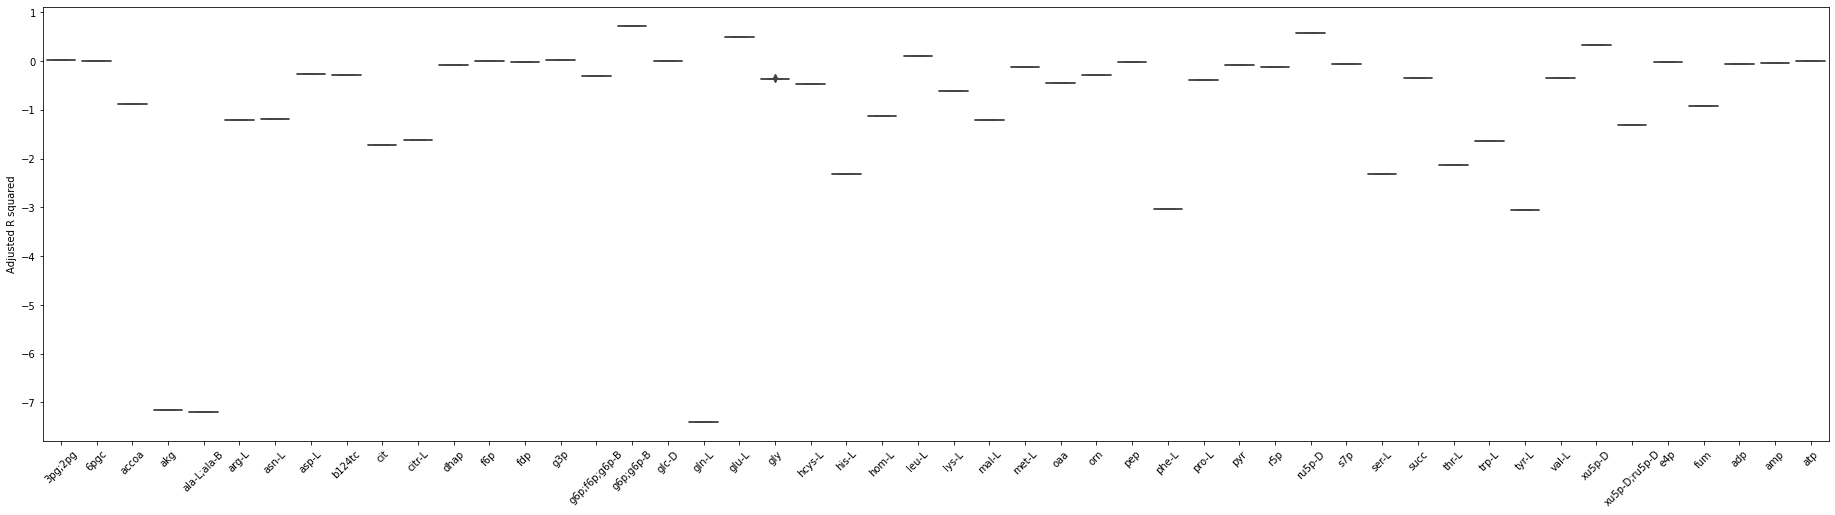

In [ ]:
fig, ax = plt.subplots(figsize=(32,8))

chart = sns.boxplot(
    data=pd.DataFrame.from_dict(results)
)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
ax.set_ylabel('Adjusted R squared')
plt.show()

# ax.hlines(0)

In [ ]:
results_df[['param_regressor__regressor', 'mean_test_score', 'rank_test_score', 'metabolite_id']].to_csv('test.csv')

In [ ]:
best_models[['param_regressor__regressor', 'mean_test_score', 'rank_test_score']]

In [ ]:
best_models = df[df['rank_test_score'] == 1]
best_models[['params', 'metabolite_id']]

KeyError: 'rank_test_score'

In [ ]:
dt: DecisionTreeRegressor = model.regressor.named_steps['select']
dt.n_features_

KeyError: 'select'

In [ ]:
len(set(y_train.unique()).difference(set(y_test.unique())))

76

<AxesSubplot:xlabel='enzyme_concentration', ylabel='Count'>

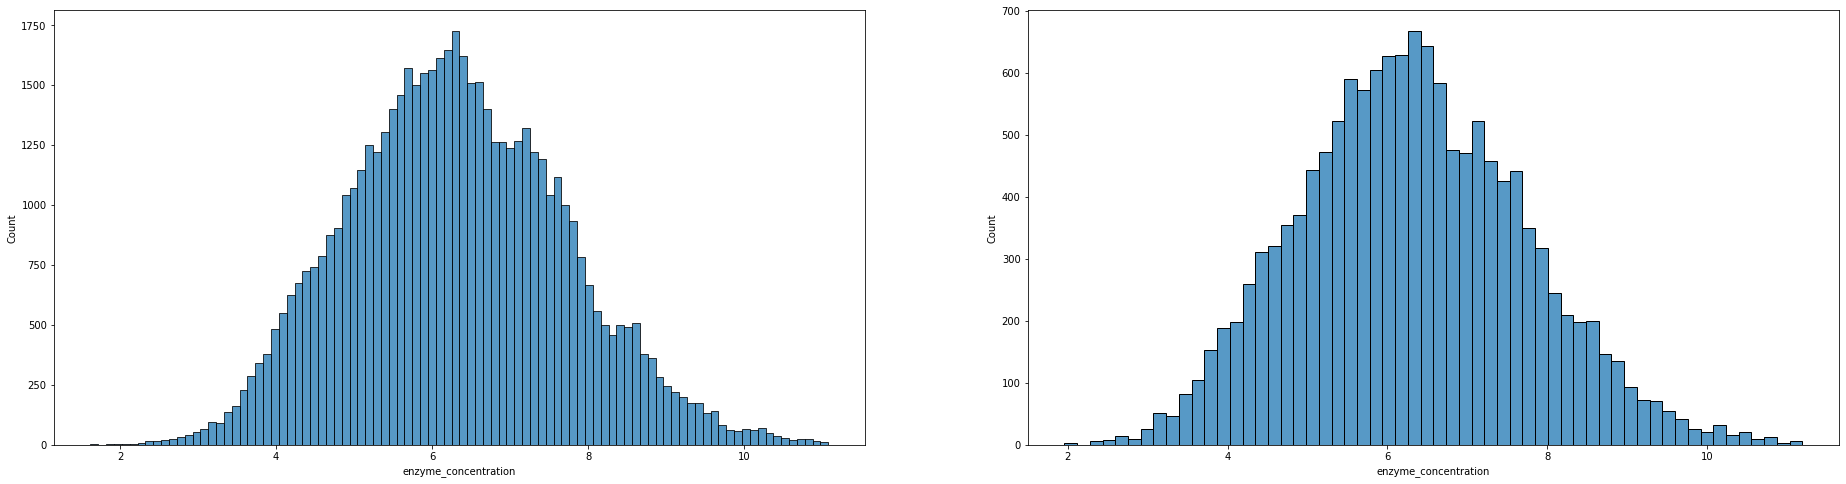

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 8))
sns.histplot(X_train['enzyme_concentration'], ax=ax1)
sns.histplot(X_test['enzyme_concentration'], ax=ax2)

<AxesSubplot:xlabel='metabolite_concentration', ylabel='Count'>

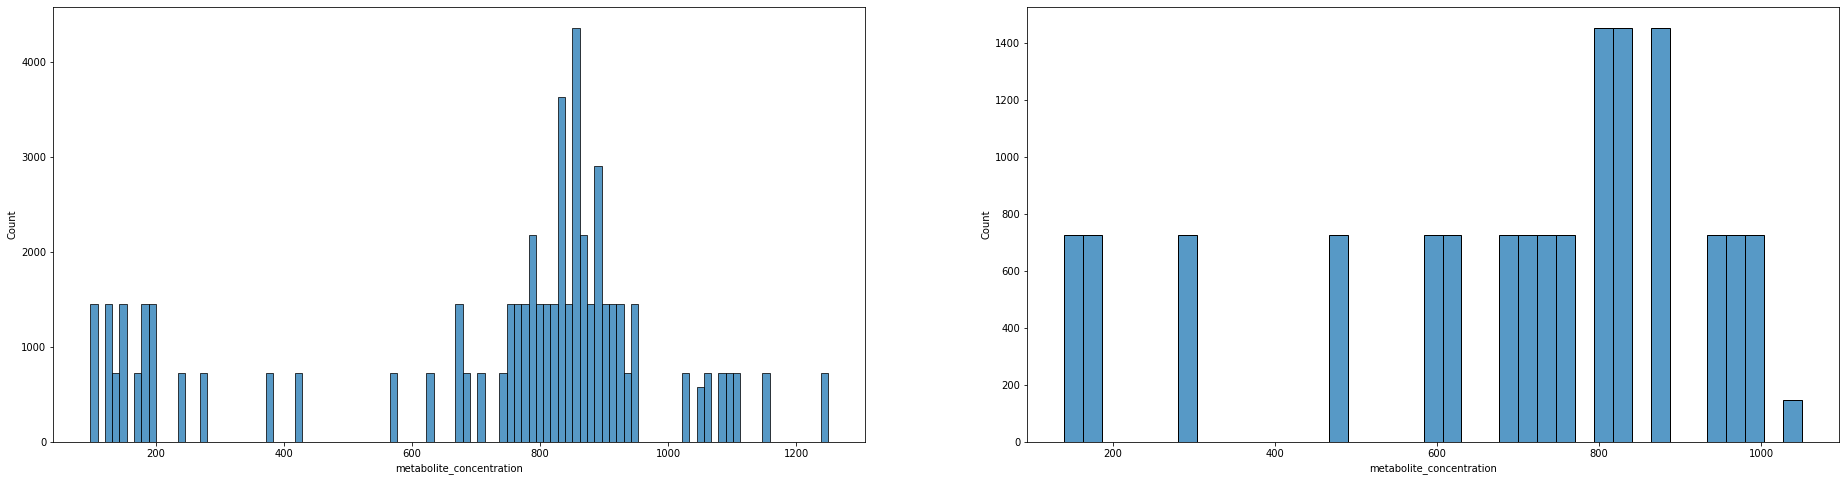

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 8))
sns.histplot(y_train, ax=ax1)
sns.histplot(y_test, ax=ax2)

In [ ]:
clf['regressor'].regressor

DecisionTreeRegressor()

In [ ]:
fig, ax = plt.subplots(figsize=(64, 64))
plot_tree(
    model.regressor.named_steps['regressor']
)

In [ ]:
transform = make_column_transformer(
    (OneHotEncoder(), ['KO_ORF', 'ORF'])
)

In [ ]:

df = transform.fit_transform(df)



In [ ]:
X_train

,KO_ORF,ORF,enzyme_concentration
36254,YJL165C,YPL028W,7.928044
28857,YHR135C,YMR116C,9.429324
58631,YOL113W,YMR203W,5.563761
38196,YJR066W,YKR074W,5.023174
45294,YLL019C,YGR180C,7.942237
...,...,...,...
21243,YGL179C,YER003C,7.177314
45891,YLR096W,YDR304C,6.456569
42613,YKL166C,YLR429W,5.862710
43567,YKL171W,YAL044C,7.113592


In [ ]:
dt = DecisionTreeRegressor()

dt.fit(X_train, y_train)
dt.score(X_test, y_test)

mean_squared_error(y_test, dt.predict(X_test))

ValueError: could not convert string to float: 'YJL165C'

In [ ]:
svr = SVR()
svr.score(X_test, y_test)

In [ ]:
mean_squared_error(y_test, svr.predict(X_test))